# 正则化逻辑回归

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt

In [341]:
path = "ex2data2.txt"
data = pd.read_csv(path,header=None,names=["test 1","test 2","result"])
data.head()

,test 1,test 2,result
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


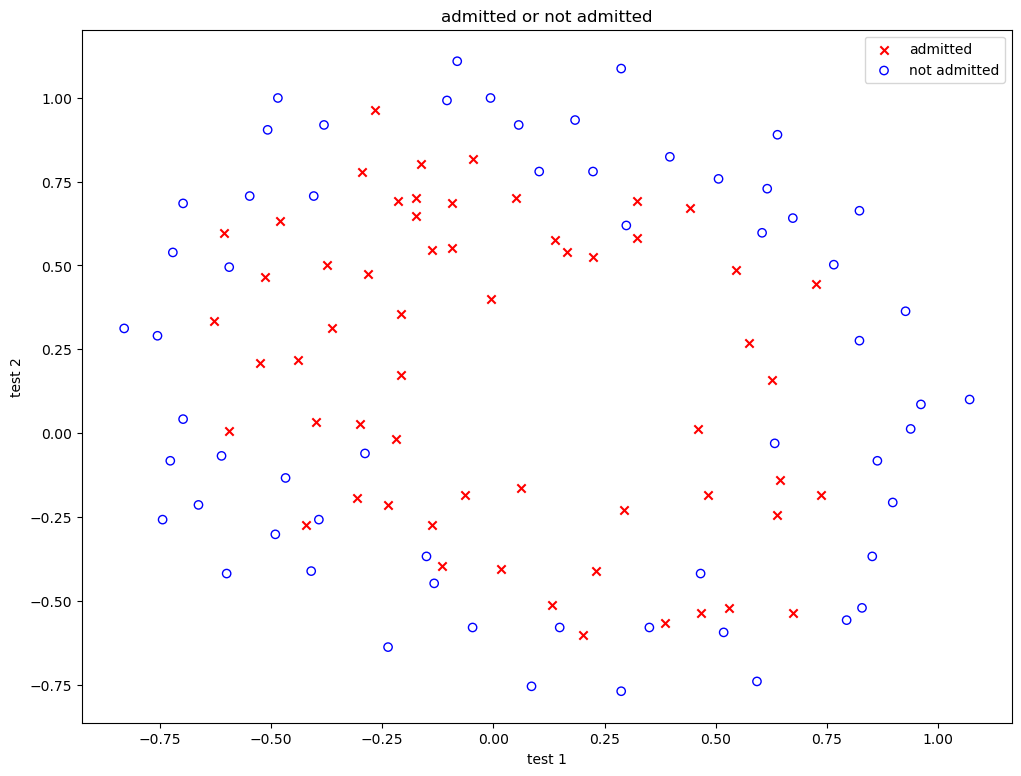

In [342]:
positive = data[data["result"] == 1]
negative = data[data["result"] == 0]
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.scatter(positive["test 1"],positive["test 2"],color="r",marker="x",label="admitted")
ax.scatter(negative["test 1"],negative["test 2"],edgecolors="b",facecolors="none",marker="o",label="not admitted")
ax.legend()
ax.set_xlabel("test 1")
ax.set_ylabel("test 2")
ax.set_title("admitted or not admitted")
plt.show()

利用逻辑回归，找到决策边界

In [343]:
# 获取数据
cols = data.shape[1]
data.insert(3,"ones",1)

通过构建多项式来建造模型

In [344]:
degree = 5
x_1 = data["test 1"]
x_2 = data["test 2"]

for i in range(1,degree):
    for j in range(0,i):
        data["F" + str(i) + str(j)] = np.power(x_1,(i - j)) * np.power(x_2,j)

data.drop("test 1",axis=1,inplace=True)
data.drop("test 2",axis=1,inplace=True)
data.head()

,result,ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是成本函数：

## regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [345]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [346]:
def cost(theta,X,y,lambda_reg):
    first = -y * np.log(sigmoid(X@theta.T))
    second = (1-y) * np.log(1-sigmoid(X@theta.T))
    # 注意theta中theta_0是不需要正则化的
    reg = (lambda_reg  / (2 * len(X))) * np.sum(theta[1:] ** 2)
    
    return np.sum(first-second) / len(X) + reg

注意等式中的"reg" 项。还注意到另外的一个“lambda_”参数。这是一种超参数，用来控制正则化项。现在我们需要添加正则化梯度函数：

$\frac{\partial J}{\partial\theta_j}=\begin{cases}\frac{1}{m}\sum_{i=1}^m(h^{(i)}-y^{(i)})x_j^{(i)}&j=0\\\frac{1}{m}\sum_{i=1}^m(h^{(i)}-y^{(i)})x_j^{(i)}+\frac{\lambda}{m}\theta_j&j\geq1&\end{cases}$

In [347]:
def gradient(theta, X, y, lambda_reg):
    m = len(y)
    h = sigmoid(X@(theta.T))
    # 计算基础梯度（未正则化部分）
    grad = ((X.T)@(h - y)) / m
    # 添加正则化项（排除theta0）
    grad[1:] += (lambda_reg / m) * theta[1:]
    return grad
    

In [348]:
cols = data.shape[1]
x_train = data.iloc[:,1:cols]
y_train = data["result"]

现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是成本函数：

In [349]:
x = np.array(x_train.values)
y = np.array(y_train.values)
x.shape,y.shape

((118, 11), (118,))

In [350]:
theta = np.zeros(x.shape[1])
theta.shape

(11,)

In [351]:
lambda_reg = 1
cost(theta,x,y,lambda_reg)

0.6931471805599454

In [352]:
gradient(theta,x,y,lambda_reg)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\
 & \text{     }{{\theta }_{j}}={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}\{{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+{\lambda }{{\theta }_{j}}\} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

In [353]:
def compute_gradient(theta, X, y, alpha, iters, lambda_reg):
    temp = np.zeros_like(theta)
    m,n = X.shape
    J_theta = []
    for i in range(iters):
        grad = gradient(theta, X, y, lambda_reg)
        temp = theta - alpha * grad
        theta = temp
        J_theta.append(cost(theta, X, y, lambda_reg))

        if i % math.ceil(iters / 100) == 0:
            print(f"iterations:{i:4d},theta:{theta},J_theta:{J_theta[-1]}")
    return theta,J_theta

In [354]:
alpha = 0.3
iters = 100000
fina_theta,J_theta = compute_gradient(theta,x,y,alpha,iters,lambda_reg)

iterations:   0,theta:[-0.00254237 -0.00563643 -0.01510339 -0.0034504  -0.0055068  -0.00219718
 -0.00245773 -0.01180459 -0.00067177 -0.00385802 -0.00092878],J_theta:0.6915860555752655
iterations:1000,theta:[ 0.52825979  0.28948919 -1.61409783 -0.56841037  0.00679409 -0.22448388
 -0.38530127 -1.3562593   0.01369451 -0.90091805  0.01497032],J_theta:0.6227000735948123
iterations:2000,theta:[ 0.53007496  0.29071618 -1.60816341 -0.58113144  0.01735011 -0.21411293
 -0.39971719 -1.37031535  0.02205241 -0.94713467  0.03293562],J_theta:0.6226825151462608
iterations:3000,theta:[ 0.53010065  0.29074849 -1.60732442 -0.58206126  0.01778625 -0.21335414
 -0.40022222 -1.37136069  0.02259957 -0.95012922  0.034307  ],J_theta:0.622682439191489
iterations:4000,theta:[ 0.53010048  0.29075035 -1.60725509 -0.58213198  0.01780961 -0.21330007
 -0.40023909 -1.37144537  0.02263779 -0.95032918  0.03440256],J_theta:0.6226824388282393
iterations:5000,theta:[ 0.53010038  0.29075037 -1.60724971 -0.58213716  0.0178112

## SciPy的“optimize”

In [355]:
result = opt.fmin_tnc(func=cost,x0=theta,fprime=gradient,args=(x,y,lambda_reg))
print(result)

(array([ 0.5301025 ,  0.29075567, -1.60725763, -0.5821382 ,  0.01781026,
       -0.21329509, -0.40024141, -1.37144138,  0.02264303, -0.9503358 ,
        0.03440849]), 22, 1)


In [356]:
def predict(theta,X):
    probability = sigmoid(X@theta.T)
    predictions = []
    for x in probability:
        if x > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [357]:
def judge(predictions,y):
    correct = []
    for (a,b) in zip(predictions,y):
        if (a == 1 and b == 1) or (a == 0 and b == 0):
            correct.append(1)
        else:
            correct.append(0)
    return correct

In [358]:
predictions = predict(result[0],x)
print(predictions)
correct = judge(predictions,y)
accuracy = sum(correct) / len(correct)
print(f"accuracy = {accuracy*100:2f}%")

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
accuracy = 66.101695%


## 使用sklearn

In [359]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x[:,1:],y)

LogisticRegression()

In [360]:
theta = model.coef_
b = model.intercept_
print(theta)
print(b)
model.score(x[:,1:],y)

[[ 0.2893168  -1.60979546 -0.5776363   0.0212225  -0.21331902 -0.40550398
  -1.36771172  0.02308467 -0.94743875  0.03147849]]
[0.5306077]


0.6610169491525424

## 可视化展示

In [378]:
data2 = pd.read_csv(path,header=None,names=["test 1","test 2","result"])
x_1 = np.linspace(data2["test 1"].min() - 0.1,data2["test 1"].max() + 0.1,500)
x_2 = np.linspace(data2["test 2"].min() - 0.1,data2["test 2"].max() + 0.1,500)
xx1,xx2 = np.meshgrid(x_1,x_2)
xx1.shape,xx2.shape

((500, 500), (500, 500))

* 创建覆盖数据范围的密集网格
* 每个网格点都转换为与训练数据相同的多项式特征
* 250000个点用于绘制平滑的决策边界

In [379]:
def map_feature(x1, x2, degree=5):
    m = x1.size
    out = np.ones((m, 1))  # 包含截距项
    for i in range(1, degree):
        for j in range(0, i):
            # 生成 x1^(i-j)*x2^j 特征列
            new_feature = (x1**(i-j) * x2**j).reshape(-1,1)
            out = np.hstack((out, new_feature))
    return out

In [384]:
X_grid = map_feature(xx1.ravel(), xx2.ravel())
print(X_grid.shape)
# 三种模型的预测结果
# 手动梯度下降模型
manual_z = sigmoid(X_grid @ fina_theta).reshape(xx1.shape) # 应用sigmoid函数得到概率值 重塑为500x500的网格形状 在绘图时只取计算结果为0.5的值，即为决策边界
# SciPy优化模型
scipy_z = sigmoid(X_grid @ result[0]).reshape(xx1.shape)# 应用sigmoid函数得到概率值 重塑为500x500的网格形状 在绘图时只取计算结果为0.5的值，即为决策边界
# sklearn模型（需要添加截距项）
sklearn_z = model.predict_proba(X_grid[:,1:])[:,1].reshape(xx1.shape)  # 排除第一列的ones # 应用sigmoid函数得到概率值 重塑为500x500的网格形状 在绘图时只取计算结果为0.5的值，即为决策边界


(250000, 11)


C:\Users\PC\AppData\Local\Temp\ipykernel_17868\573693849.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(xx1, xx2, manual_z, levels=[0.5], colors='green', linewidths=2,label="Manual Gradient Descent")
C:\Users\PC\AppData\Local\Temp\ipykernel_17868\573693849.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(xx1, xx2, scipy_z, levels=[0.5], colors='orange', linewidths=2, linestyles='--',label="SciPy Optimized")
C:\Users\PC\AppData\Local\Temp\ipykernel_17868\573693849.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  ax[2].contour(xx1, xx2, sklearn_z, levels=[0.5], colors='purple', linewidths=2, linestyles=':',label="Sklearn Model")


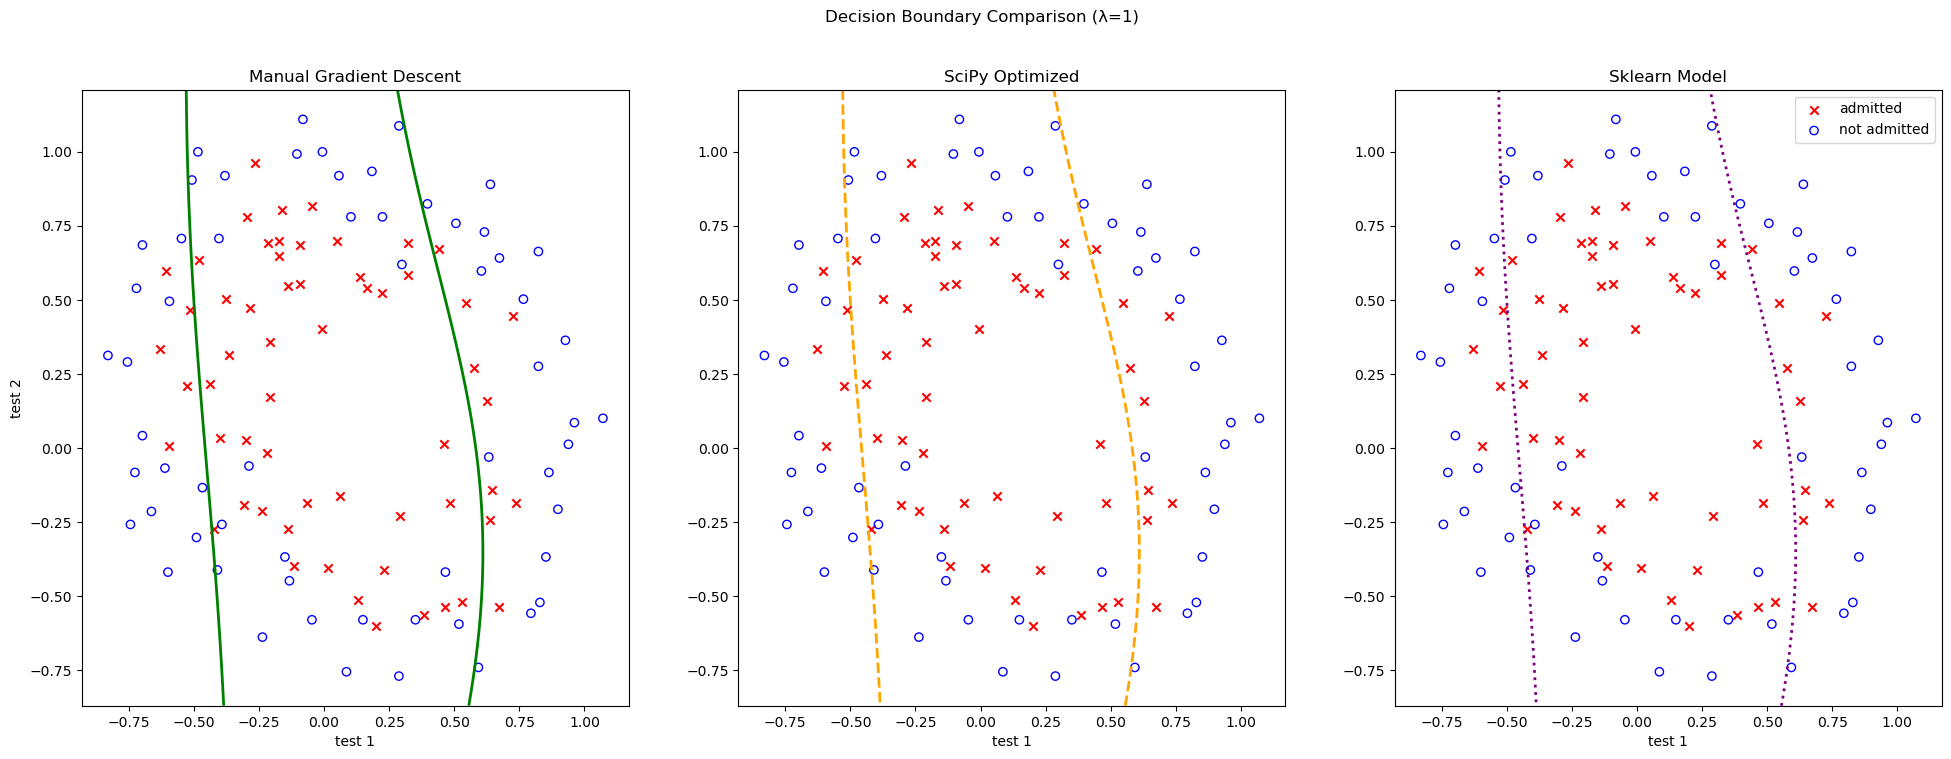

In [385]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
for i in range(3):
    ax[i].scatter(positive["test 1"],positive["test 2"],color="r",marker="x",label="admitted")
    ax[i].scatter(negative["test 1"],negative["test 2"],edgecolor="b",facecolors="none",marker="o",label="not admitted")
    ax[i].set_xlabel("test 1")
ax[0].set_ylabel("test 2")

# 绘制决策边界
ax[0].contour(xx1, xx2, manual_z, levels=[0.5], colors='green', linewidths=2,label="Manual Gradient Descent")
ax[1].contour(xx1, xx2, scipy_z, levels=[0.5], colors='orange', linewidths=2, linestyles='--',label="SciPy Optimized")
ax[2].contour(xx1, xx2, sklearn_z, levels=[0.5], colors='purple', linewidths=2, linestyles=':',label="Sklearn Model")

# 添加标签和图例
ax[0].set_title('Manual Gradient Descent')
ax[1].set_title('SciPy Optimized')
ax[2].set_title('Sklearn Model')
plt.suptitle('Decision Boundary Comparison (λ=1)')
plt.legend(loc='upper right')
plt.show()

plt.show()